In [1]:
%load_ext autoreload
%autoreload 2

import utils
from darts import TimeSeries
import numpy as np
import pandas as pd
from darts.models import NaiveSeasonal
from darts.metrics import rmse, mape, r2_score, mae
import matplotlib.pyplot as plt

In [2]:
# Load data
df = utils.load_data()

# Convert the dataframe to multiple TimeSeries objects (one per pre-processing method)
ts, covars_diff, covars_diff_yoy, covars_nodiff = utils.df2ts(df)

# Scale the time series and covariates
covars_diff_pipeline, covars_diff_scaled = utils.scale_ts(covars_diff, should_diff=True, diff_order=1)
covars_nodiff_pipeline, covars_nodiff_scaled = utils.scale_ts(covars_nodiff, should_diff=False)
covars_diff_yoy_pipeline, covars_diff_yoy_scaled = utils.scale_ts(covars_diff_yoy,should_diff=True, diff_order=12)
pipeline, ts_scaled = utils.scale_ts(ts, should_diff=True, diff_order=1)


# Ensure that all covariates are aligned (i.e. have the same time range). This is required for stacking them together.
covars_diff_scaled = covars_diff_scaled.slice_intersect(covars_nodiff_scaled).slice_intersect(covars_diff_yoy_scaled)
covars_nodiff_scaled = covars_nodiff_scaled.slice_intersect(covars_diff_scaled).slice_intersect(covars_diff_yoy_scaled)
covariates_scaled = covars_diff_scaled.stack(covars_nodiff_scaled).stack(covars_diff_yoy_scaled)


# Split the data into training and validation sets
train_ts_scaled, val_ts_scaled = ts_scaled.split_after(pd.Timestamp("2016-01-01"))
train_covariates_scaled, val_covariates_scaled = covariates_scaled.split_after(
    pd.Timestamp("2016-01-01")
)

# Naive Model

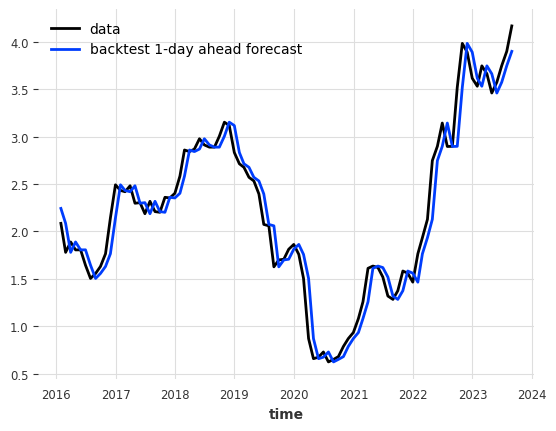

,h,mape,rmse,r2,mae
0,1,7.703667,0.199121,0.949089,0.145772
1,2,13.698501,0.330233,0.861459,0.250774
2,3,18.232449,0.426595,0.770728,0.321901
3,4,22.748020,0.505532,0.681101,0.394540
4,5,26.932014,0.577666,0.587239,0.463551
5,6,31.113430,0.655761,0.472777,0.534647
6,7,34.924240,0.728407,0.353732,0.599800
7,8,38.514225,0.795953,0.231262,0.658137
8,9,42.382820,0.864049,0.098450,0.722138
9,10,45.931522,0.930050,-0.038108,0.781228


In [3]:
model = NaiveSeasonal()
model.fit(train_ts_scaled)

results = []
for h in range(1, 13):
    historical_fcast_theta = model.historical_forecasts(
        last_points_only=True,
        series=ts,
        start=pd.Timestamp("2016-01-01"),
        forecast_horizon=h,
        verbose=False,
        past_covariates=None,
        enable_optimization=False,
    )

    if h == 1:
        ts.drop_before(pd.Timestamp("2016-01-01")).plot(label="data")
        historical_fcast_theta.plot(label="backtest 1-day ahead forecast")
        plt.show()

    mapee = mape(ts, historical_fcast_theta)
    rmsee = rmse(ts, historical_fcast_theta)
    r2 = r2_score(ts, historical_fcast_theta)
    maee = mae(ts, historical_fcast_theta)

    results.append([h, mapee, rmsee, r2, maee])

results = pd.DataFrame(results, columns=["h", "mape", "rmse", "r2", "mae"])
results

# AR Model

In [7]:
from darts.models import LinearRegressionModel

best_lag = 1
best_mape = np.inf

for lag in range(1, 18):
    model = LinearRegressionModel(lags=lag)
    model.fit(train_ts_scaled)
    mapee, rmsee, r2 = eval_model_for_h(1, model, ts)
    if mapee < best_mape:
        best_mape = mapee
        best_lag = lag

f"Best lag: {best_lag}, MAPE: {best_mape}"

'Best lag: 2, MAPE: 7.156896114349365'

In [8]:
covars = covariates_scaled["NEWS_SENTIMENT"]

model = LinearRegressionModel(lags=3, lags_past_covariates=[-3])
model.fit(train_ts_scaled, past_covariates=covars)
mapee, rmsee, r2 = eval_model_for_h(1, model, ts, past_covariates=covars)

In [9]:
model.lagged_feature_names

['US_TB_YIELD_10YRS_target_lag-2',
 'US_TB_YIELD_10YRS_target_lag-1',
 'NEWS_SENTIMENT_pastcov_lag-3']

In [10]:
model.model.coef_

array([-0.18125054,  0.3544559 ,  0.05573623], dtype=float32)

In [11]:
mapee

7.3510723

# Pytorch-based models

## RNN

In [12]:
from darts.dataprocessing import Pipeline
from darts.dataprocessing.transformers import (
    Scaler,
    MissingValuesFiller,
    Mapper,
    InvertibleMapper,
    Diff,
)
from sklearn.preprocessing import StandardScaler

log_transformer = InvertibleMapper(fn=np.log1p, inverse_fn=np.expm1, name="log1p")
scaler = Scaler(StandardScaler())
filler = MissingValuesFiller()
differentiator = Diff(dropna=True)
pipeline = Pipeline([filler, log_transformer, scaler, differentiator])
covariates_pipeline = Pipeline([filler, log_transformer, scaler, differentiator])


covariates_scaled = covariates_pipeline.fit_transform(covariates)
ts_scaled = pipeline.fit_transform(ts)
train_ts_scaled, val_ts_scaled = ts_scaled.split_after(pd.Timestamp("2016-01-01"))
train_covariates_scaled, val_covariates_scaled = covariates_scaled.split_after(
    pd.Timestamp("2016-01-01")
)

NameError: name 'covariates' is not defined

In [14]:
from darts.models import BlockRNNModel
from darts.utils.likelihood_models import GaussianLikelihood
from torch.optim.lr_scheduler import CosineAnnealingLR
from pytorch_lightning.callbacks.early_stopping import EarlyStopping


early_stopper = EarlyStopping(
    monitor="val_loss", patience=5, min_delta=1e-6, mode="min"
)

model = BlockRNNModel(
    random_state=0,
    model_name="block_rnn",
    log_tensorboard=True,
    save_checkpoints=True,
    force_reset=True,
    show_warnings=True,
    pl_trainer_kwargs={"callbacks": [early_stopper]},
    model="GRU",  # The type of RNN to use. One of: “LSTM”, “GRU” or “RNN”
    input_chunk_length=12,  # Number of time steps in the past to take as a model input (per chunk).
    output_chunk_length=1,  # Number of time steps predicted at once (per chunk) by the internal model
    n_epochs=100,
    optimizer_kwargs={"lr": 1e-3},
    dropout=0.2,  # Fraction of neurons afected by Dropout.
    hidden_dim=30,  # Size for feature maps for each hidden RNN layer ()
    activation="TanH",  # The name of a torch.nn activation function to be applied between the layers of the fully connected network. Default: “ReLU”.
    batch_size=16,
    n_rnn_layers=2,  # Number of layers in the RNN module.
    lr_scheduler_cls=CosineAnnealingLR,
    lr_scheduler_kwargs={
        "T_max": 20,
        "eta_min": 1e-4,
    },  # The maximum number of epochs in the cosine annealing scheduler
    use_reversible_instance_norm=True,
    # likelihood=GaussianLikelihood(), # https://unit8co.github.io/darts/generated_api/darts.utils.likelihood_models.html#darts.utils.likelihood_models.Likelihood
    # hidden_fc_sizes=[20, 20], # Size of the fully connected layers between the RNN and the output layer
)


model.fit(
    train_ts_scaled,
    val_series=val_ts_scaled,
    verbose=True,
    past_covariates=train_covariates_scaled,
    val_past_covariates=val_covariates_scaled,
)


# model = BlockRNNModel.load_from_checkpoint("block_rnn")

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rin             | RINorm           | 2      | train
6 | rnn             | GRU              | 8.9 K  | train
7 | fc              | Sequential       | 31     | train
-------------------------------------------------------------
8.9 K     Trainable params
0         Non-trainable params
8.9 K     Total params
0.036     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/Xavier/cdpq-ia/venv/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Users/Xavier/cdpq-ia/venv/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Users/Xavier/cdpq-ia/venv/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (40) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

BlockRNNModel(output_chunk_shift=0, model=GRU, hidden_dim=30, n_rnn_layers=2, hidden_fc_sizes=None, dropout=0.2, activation=TanH, random_state=0, model_name=block_rnn, log_tensorboard=True, save_checkpoints=True, force_reset=True, show_warnings=True, pl_trainer_kwargs={'callbacks': [<pytorch_lightning.callbacks.early_stopping.EarlyStopping object at 0x35cef7350>]}, input_chunk_length=12, output_chunk_length=1, n_epochs=100, optimizer_kwargs={'lr': 0.001}, batch_size=16, lr_scheduler_cls=<class 'torch.optim.lr_scheduler.CosineAnnealingLR'>, lr_scheduler_kwargs={'T_max': 20, 'eta_min': 0.0001}, use_reversible_instance_norm=True)

In [15]:
hfc_params = {
    "series": ts_scaled,
    "past_covariates": covariates_scaled,
    "start": pd.Timestamp(
        "2016-01-01"
    ),  # can also be a float for the fraction of the series to start at
    "forecast_horizon": 1,
    "verbose": True,
    "retrain": False,
}

historical_fcast_block_rnn = model.historical_forecasts(
    last_points_only=True, **hfc_params
)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/Xavier/cdpq-ia/venv/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

rmse = 0.58
mape = 28.34%
r2 = 0.71


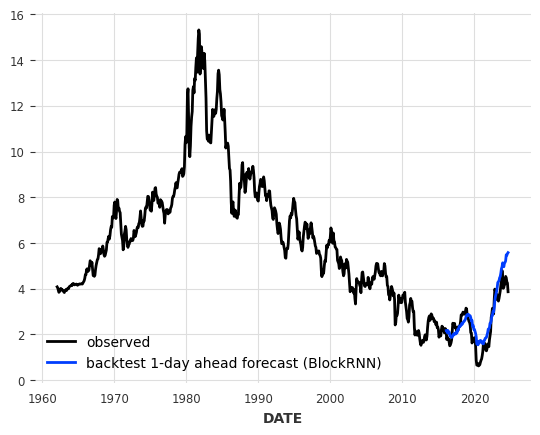

In [16]:
historical_fcast_block_rnn = train_ts_scaled.append(historical_fcast_block_rnn)
historical_fcast_block_rnn = pipeline.inverse_transform(
    historical_fcast_block_rnn, partial=True
)
historical_fcast_block_rnn = historical_fcast_block_rnn.drop_before(
    pd.Timestamp("2016-01-01")
)

ts.plot(label="observed")
historical_fcast_block_rnn.plot(label="backtest 1-day ahead forecast (BlockRNN)")

print(f"rmse = {rmse(ts, historical_fcast_block_rnn):.2f}")
print(f"mape = {mape(ts, historical_fcast_block_rnn):.2f}%")
print(f"r2 = {r2_score(ts, historical_fcast_block_rnn):.2f}")